# ĐỌC DỮ LIỆU

In [69]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tensorflow.keras.layers import  Dropout
from tensorflow.keras.layers import  Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import  Conv2D
from tensorflow.keras.layers import  MaxPool2D
from sklearn import preprocessing
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
import pathlib
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import adam_v2

In [30]:
Y_train = pd.read_csv('./train_v2.csv')
Y_validation = pd.read_csv('./validation_v2.csv')

In [31]:
X_train = []
for i in range(len(Y_train)):
    img_dir = './1train/'+ Y_train.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, 0)
    X_train.append(img)
  

In [32]:
X_validation = []
for i in range(len(Y_validation)):
    img_dir = './1validation/'+ Y_validation.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, 0)
    X_validation.append(img)

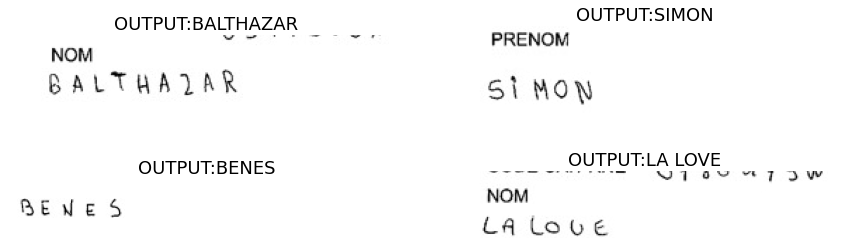

In [33]:
plt.figure(figsize=(15, 15))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    image = X_train[i]
    plt.imshow(image, cmap = 'gray')
    plt.title('OUTPUT:' +Y_train.loc[i, 'IDENTITY'], fontsize=18)
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=-0.8)

# TIỀN XỬ LÝ DỮ LIỆU

## Loại bỏ dữ liệu Nans

In [34]:
print("Số phần tử rỗng trong train               : ", Y_train['IDENTITY'].isnull().sum())
print("Số phần tử rỗng trong train validation    : ", Y_validation['IDENTITY'].isnull().sum())
# print("Số phần tử rỗng trong train test          : ", Y_test['IDENTITY'].isnull().sum())

Số phần tử rỗng trong train               :  0
Số phần tử rỗng trong train validation    :  0


In [35]:
Y_train = Y_train.dropna()
Y_validation = Y_validation.dropna()
# Y_test = Y_test.dropna()

In [36]:
print("Số phần tử rỗng trong train                  : ", Y_train['IDENTITY'].isnull().sum())
print("Số phần tử rỗng trong train validation       : ", Y_validation['IDENTITY'].isnull().sum())
# print("Số phần tử rỗng trong test                 : ", Y_test['IDENTITY'].isnull().sum())

Số phần tử rỗng trong train                  :  0
Số phần tử rỗng trong train validation       :  0


In [37]:
Y_train.shape 

(500, 2)

## Loại bỏ biến có giá trị "UNREADABLE" trong các tệp Y

In [38]:
unreadable_train = Y_train[Y_train['IDENTITY'] == 'UNREADABLE']
unreadable_validation= Y_validation[Y_validation['IDENTITY'] == 'UNREADABLE']

unreadable_train.reset_index(inplace = True, drop=True)
unreadable_validation.reset_index(inplace = True, drop=True)


In [39]:
unreadable_train

,FILENAME,IDENTITY


In [40]:
unreadable_validation

,FILENAME,IDENTITY
0,VALIDATION_0006.jpg,UNREADABLE


In [41]:
# plt.figure(figsize=(15, 10))

# for i in range(4):
#     ax = plt.subplot(2, 2, i+1)
#     img_dir = './train/'+unreadable_train.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, 0)
#     plt.imshow(image, cmap = 'gray')
#     plt.title(unreadable_train.loc[i, 'IDENTITY'], fontsize=12)
#     plt.axis('off')
# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [42]:
Y_train = Y_train[Y_train['IDENTITY'] != 'UNREADABLE']
Y_validation = Y_validation[Y_validation['IDENTITY'] != 'UNREADABLE']

In [43]:
Y_train.reset_index(inplace = True, drop=True) 
Y_validation.reset_index(inplace = True, drop=True)

In [44]:
X_train = []
for i in range(len(Y_train)):
    img_dir = './train/'+ Y_train.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, 0)
    X_train.append(img)
  

In [45]:
X_validation = []
for i in range(len(Y_validation)):
    img_dir = './valid/'+ Y_validation.loc[i, 'FILENAME']
    img = cv2.imread(img_dir, 0)
    X_validation.append(img)

In [46]:
len( X_validation),len (X_train)

(99, 500)

## Đồng bộ kích thước ảnh

In [47]:
X_width_train = []
X_height_train = []
X_height_width_train = []
for i in range(len(Y_train)):
    X_width_train.append(X_train[i].shape[1])
    X_height_train.append(X_train[i].shape[0])
    X_height_width_train.append(X_width_train[i]/X_height_train[i])

In [48]:
def preprocess(img):
    (height, width) = img.shape
    final_img = np.ones([64, 256])*255
    if width > 256:
        #lất tất cả hàng và từ 0 => max width cột
        img = img[:, 0:256]
    if height > 64:
        #lấy tất cả cột và từ 0 => 64 hàng
        img = img[0:64, :]
        #lấy lại chiều dài và chiều rộng ảnh
    (height, width) = img.shape
        # lấy từ côt 0 => width lấy từ hàng 0 => height bằng ảnh đã cho , còn lại gán bằng -1
    final_img[0:height, 0:width] = img
    return final_img

In [49]:
train_x = []
for i in range(len (X_train)):
    image = preprocess(X_train[i])
    train_x.append(image)

In [50]:
train_x[1].shape

(64, 256)

In [51]:
validation_x = []
for i in range(len (X_validation)):
    image = preprocess(X_validation[i])
    validation_x.append(image)

## Đưa data về phân bố từ 0 đến 1

In [52]:
# train_x[1]/255.0
for i in range(len(train_x)):
    train_x[i]= train_x[i]/255.0

In [53]:
for i in range(len(validation_x)):
    validation_x[i]= validation_x[i]/255.0

In [54]:
    validation_x[1].shape

(64, 256)

In [55]:
validation_x = np.array(validation_x).reshape(-1, 64,256, 1)

In [56]:
train_x = np.array(train_x).reshape(-1, 64 , 256, 1)

## Tạo lable

In [57]:
list_lable = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(list_lable) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(list_lable.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=list_lable[ch]
    return ret

In [58]:
len(list_lable)

29

In [59]:
train_size = len(Y_train)
valid_size = len(Y_validation)
train_size, valid_size

(500, 99)

In [60]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(Y_train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(Y_train.loc[i, 'IDENTITY'])]= label_to_num(Y_train.loc[i, 'IDENTITY'])    

In [61]:
validation_y = np.ones([valid_size, max_str_len]) * -1
validation_label_len = np.zeros([valid_size, 1])
validation_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
validation_output = np.zeros([valid_size])

for i in range(valid_size):
   validation_label_len[i] = len(Y_validation.loc[i, 'IDENTITY'])
   validation_y[i, 0:len(Y_validation.loc[i, 'IDENTITY'])]= label_to_num(Y_validation.loc[i, 'IDENTITY'])  

# CHUAN BỊ CHO CTC
 

# CNN


In [62]:
input_data = Input(shape=(64, 256, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)


inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)


# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 256, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 64, 256, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 64, 256, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 256, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 32, 128, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 32, 128, 64)       18496     
                                                             

In [63]:
labels = Input(name='the_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
  
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) 

#model to be used at training time
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

In [64]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred})


In [65]:
train_label_len=np.array(train_label_len).reshape(-1,1)
train_label_len

array([[ 9.],
       [ 5.],
       [ 5.],
       [ 7.],
       [ 6.],
       [ 5.],
       [ 6.],
       [ 8.],
       [ 6.],
       [ 5.],
       [ 4.],
       [ 9.],
       [ 5.],
       [ 7.],
       [ 6.],
       [11.],
       [ 7.],
       [ 8.],
       [ 8.],
       [ 6.],
       [ 4.],
       [ 8.],
       [ 5.],
       [ 8.],
       [ 8.],
       [ 6.],
       [ 6.],
       [ 5.],
       [ 5.],
       [ 7.],
       [ 4.],
       [ 7.],
       [ 6.],
       [ 8.],
       [ 5.],
       [ 8.],
       [ 5.],
       [ 7.],
       [ 8.],
       [ 6.],
       [ 6.],
       [ 6.],
       [ 5.],
       [ 8.],
       [ 5.],
       [12.],
       [ 5.],
       [ 9.],
       [ 7.],
       [11.],
       [ 4.],
       [ 5.],
       [14.],
       [ 7.],
       [ 6.],
       [ 5.],
       [ 8.],
       [ 5.],
       [ 7.],
       [15.],
       [ 6.],
       [ 6.],
       [ 4.],
       [ 6.],
       [ 7.],
       [ 5.],
       [ 5.],
       [11.],
       [ 4.],
       [ 6.],
       [ 9.],
      

In [66]:
model.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([validation_x, validation_y, validation_input_len, validation_label_len], validation_output),
                epochs=60, batch_size=128)

Epoch 1/60
4/4 [==============================] - 94s 20s/step - loss: 128.5745 - val_loss: 24.1134
Epoch 2/60
4/4 [==============================] - 62s 16s/step - loss: 22.7337 - val_loss: 21.5530
Epoch 3/60
4/4 [==============================] - 61s 16s/step - loss: 21.4862 - val_loss: 21.0478
Epoch 4/60
4/4 [==============================] - 70s 18s/step - loss: 21.7561 - val_loss: 22.8351
Epoch 5/60
4/4 [==============================] - 84s 21s/step - loss: 22.0259 - val_loss: 21.1581
Epoch 6/60
4/4 [==============================] - 122s 33s/step - loss: 21.1915 - val_loss: 21.1410
Epoch 7/60
4/4 [==============================] - 112s 27s/step - loss: 21.5643 - val_loss: 22.3047
Epoch 8/60
4/4 [==============================] - 105s 27s/step - loss: 22.0597 - val_loss: 21.7332
Epoch 9/60
4/4 [==============================] - 98s 24s/step - loss: 21.1742 - val_loss: 20.9393
Epoch 10/60
4/4 [==============================] - 97s 25s/step - loss: 20.8890 - val_loss: 21.2023
Epoch

In [67]:
model.save("mdsv.h5")